```
         Copyright Rein Halbersma 2020-2021.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Chapter 5 Monte Carlo Methods

## 5.1 Monte Carlo Prediction

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from doctrina.algorithms import dp, mc
from doctrina.spaces import shape, size, state_table
import gym_blackjack_v1 as bj

env = gym.make('Blackjack-v1', model_based=True)
env.seed(47110815)

[47110815]

## The payout

In [2]:
pd.DataFrame(
    env.payout,
    index=bj.count_labels,  # player count
    columns=bj.count_labels # dealer count
)

,BUST,<17,17,18,19,20,21,BJ
BUST,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
<17,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
17,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0
19,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0
20,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0
21,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0
BJ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


**Example 5.1: Blackjack**

100%|██████████| 500000/500000 [00:17<00:00, 29052.71it/s]


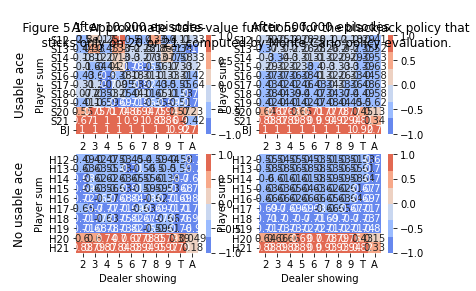

In [3]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
stand_on_20 = np.full(shape(env.observation_space), bj.Action.HIT)
stand_on_20[bj.Hand.H20:(bj.Hand.H21 + 1), :] = bj.Action.STAND
stand_on_20[bj.Hand.S20:(bj.Hand.BJ  + 1), :] = bj.Action.STAND

# In any event, after 500,000 games the value function is very well approximated.
runs = [ 10_000, 500_000 ]
Vs, Ns = zip(*[ 
    mc.predict_ev(env, episodes, stand_on_20) 
    for episodes in runs 
])

options = {
    'vmin': min(env.reward_range), 
    'vmax': max(env.reward_range), 
    'cmap': sns.color_palette('coolwarm'), 
    'center': 0.,
    'annot': True, 
    'xticklabels': bj.card_labels
}

hands = [
    np.arange(bj.Hand.S12, bj.Hand.BJ  + 1),
    np.arange(bj.Hand.H12, bj.Hand.H21 + 1)
]

yticklabels = [ 
    np.array(bj.hand_labels)[hands[no_usable_ace]] 
    for no_usable_ace in range(2)
]

axopts = {
    'xlabel': 'Dealer showing',
    'ylabel': 'Player sum'
}

fig, axes = plt.subplots(nrows=2, ncols=len(runs))
fig.suptitle(
    """
    Figure 5.1: Approximate state-value functions for the blackjack policy that
    sticks only on 20 or 21, computed by Monte Carlo policy evaluation.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ f'After {episodes:,} episodes' for episodes in runs ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    for r, _ in enumerate(runs):
        sns.heatmap(Vs[r][h, :], yticklabels=yticklabels[i], ax=axes[i, r], **options).set(**axopts)
plt.show()

In [4]:
pd.DataFrame(
    Vs[1],
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.4781,-0.4384,-0.4253,-0.4493,-0.4672,-0.3787,-0.4537,-0.4475,-0.5372,-0.6209
H5,-0.4913,-0.4610,-0.4323,-0.5012,-0.4686,-0.4881,-0.5203,-0.4825,-0.5878,-0.6233
H6,-0.4899,-0.5052,-0.5043,-0.4766,-0.5722,-0.5161,-0.4869,-0.5433,-0.5414,-0.6832
H7,-0.4965,-0.5179,-0.5053,-0.5431,-0.5031,-0.5088,-0.4916,-0.5355,-0.5756,-0.6459
H8,-0.5776,-0.5293,-0.5419,-0.5055,-0.5500,-0.5686,-0.4971,-0.5576,-0.6024,-0.6871
H9,-0.5019,-0.5124,-0.5145,-0.5162,-0.4876,-0.4833,-0.4950,-0.4613,-0.5589,-0.6534
H10,-0.1207,-0.1578,-0.1197,-0.0893,-0.0812,-0.0383,-0.0658,-0.0915,-0.2140,-0.3923
H11,-0.0884,-0.0604,-0.0874,-0.0858,-0.0674,-0.0398,-0.0301,-0.0688,-0.1306,-0.3835
H12,-0.5505,-0.5432,-0.5452,-0.5352,-0.5267,-0.5148,-0.5262,-0.5054,-0.5788,-0.6748
H13,-0.5840,-0.5821,-0.5552,-0.5798,-0.5807,-0.5284,-0.5581,-0.5479,-0.6136,-0.7081


In [5]:
# Although we have complete knowledge of the environment in the blackjack task, it
# would not be easy to apply DP methods to compute the value function.
policy = np.zeros(size(env.observation_space) + 1, dtype=int)
policy[:-1] = stand_on_20.reshape(size(env.observation_space))
V_dp, *_ = dp.V_policy_eval_deter_sync(env, policy, tol=1e-9)
pd.DataFrame(
    state_table(V_dp, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.4783,-0.4762,-0.4741,-0.4723,-0.4656,-0.4518,-0.4483,-0.4521,-0.5195,-0.6331
H5,-0.4963,-0.4943,-0.4923,-0.4905,-0.4840,-0.4707,-0.4673,-0.4710,-0.5360,-0.6458
H6,-0.5144,-0.5125,-0.5105,-0.5088,-0.5026,-0.4897,-0.4865,-0.4900,-0.5527,-0.6585
H7,-0.5322,-0.5304,-0.5285,-0.5268,-0.5209,-0.5085,-0.5053,-0.5087,-0.5692,-0.6711
H8,-0.5539,-0.5521,-0.5503,-0.5488,-0.5431,-0.5314,-0.5285,-0.5316,-0.5887,-0.6862
H9,-0.5210,-0.5189,-0.5167,-0.5148,-0.5080,-0.4939,-0.4903,-0.4950,-0.5630,-0.6636
H10,-0.1314,-0.1271,-0.1227,-0.1188,-0.1048,-0.0760,-0.0685,-0.0797,-0.2170,-0.3908
H11,-0.0755,-0.0729,-0.0701,-0.0677,-0.0589,-0.0408,-0.0364,-0.0379,-0.1301,-0.3482
H12,-0.5449,-0.5431,-0.5413,-0.5397,-0.5339,-0.5220,-0.5190,-0.5222,-0.5805,-0.6799
H13,-0.5774,-0.5757,-0.5740,-0.5726,-0.5672,-0.5561,-0.5533,-0.5563,-0.6104,-0.7028


In [6]:
# In any event, after 500,000 games the value function is very well approximated.
pd.DataFrame(
    (Vs[1] - state_table(V_dp, env)) / state_table(V_dp, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).style.format('{:,.2%}')

,2,3,4,5,6,7,8,9,T,A
H4,-0.04%,-7.94%,-10.29%,-4.86%,0.35%,-16.17%,1.20%,-1.02%,3.42%,-1.94%
H5,-1.00%,-6.74%,-12.18%,2.18%,-3.19%,3.70%,11.32%,2.44%,9.65%,-3.48%
H6,-4.76%,-1.42%,-1.21%,-6.34%,13.85%,5.38%,0.09%,10.87%,-2.04%,3.74%
H7,-6.72%,-2.36%,-4.39%,3.08%,-3.41%,0.06%,-2.72%,5.26%,1.14%,-3.76%
H8,4.30%,-4.13%,-1.54%,-7.88%,1.27%,7.00%,-5.94%,4.90%,2.32%,0.12%
H9,-3.66%,-1.25%,-0.44%,0.27%,-4.02%,-2.15%,0.97%,-6.79%,-0.72%,-1.53%
H10,-8.15%,24.13%,-2.45%,-24.82%,-22.53%,-49.61%,-3.83%,14.85%,-1.38%,0.38%
H11,17.03%,-17.09%,24.58%,26.67%,14.33%,-2.25%,-17.31%,81.51%,0.40%,10.12%
H12,1.04%,0.02%,0.73%,-0.84%,-1.35%,-1.38%,1.40%,-3.22%,-0.28%,-0.76%
H13,1.15%,1.10%,-3.27%,1.27%,2.38%,-4.98%,0.86%,-1.51%,0.53%,0.76%


## 5.3 Monte Carlo Control

**Example 5.3: Solving Blackjack**

100%|██████████| 500000/500000 [00:21<00:00, 22986.50it/s]


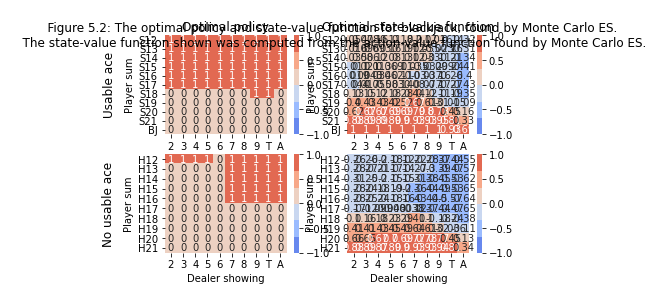

In [7]:
episodes = 500_000
policy0 = stand_on_20
policy, Q, N = mc.control_es(env, episodes, policy0)
assert (policy == Q.argmax(axis=2)).all()
policy = Q.argmax(axis=2)
V = Q.max(axis=2)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(
    """
    Figure 5.2: The optimal policy and state-value function for blackjack, found by Monte Carlo ES. 
    The state-value function shown was computed from the action-value function found by Monte Carlo ES.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ 'Optimal policy', 'Optimal state-value function' ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    sns.heatmap(policy[h, :], yticklabels=yticklabels[i], ax=axes[i, 0], **options).set(**axopts)
    sns.heatmap(     V[h, :], yticklabels=yticklabels[i], ax=axes[i, 1], **options).set(**axopts)
plt.show()

In [8]:
pd.DataFrame(
    V, 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.1309,-0.1260,-0.0739,-0.0270,0.0160,-0.0972,-0.1911,-0.2918,-0.3828,-0.4758
H5,-0.1409,-0.1087,-0.0240,-0.0455,-0.0397,-0.1416,-0.2420,-0.3060,-0.4021,-0.5149
H6,-0.1319,-0.1719,-0.0607,-0.0178,0.0022,-0.1533,-0.2023,-0.2862,-0.3868,-0.5255
H7,-0.0953,-0.0595,-0.0275,0.0228,-0.0215,-0.0947,-0.2426,-0.2593,-0.3351,-0.5498
H8,-0.0676,0.0244,0.0122,0.0481,0.1264,0.0354,-0.0574,-0.2269,-0.3339,-0.4275
H9,0.0973,0.1124,0.1025,0.1572,0.1940,0.1681,0.0890,-0.0200,-0.2551,-0.3549
H10,0.1743,0.2021,0.2554,0.3266,0.2594,0.2773,0.1927,0.1283,-0.0407,-0.2399
H11,0.2285,0.2458,0.2738,0.2634,0.3417,0.2968,0.2348,0.1370,0.0081,-0.2433
H12,-0.2610,-0.2606,-0.2046,-0.1840,-0.1200,-0.2230,-0.2810,-0.3727,-0.4450,-0.5499
H13,-0.2805,-0.2667,-0.2146,-0.1731,-0.1389,-0.2683,-0.3038,-0.3904,-0.4750,-0.5740


In [9]:
pd.DataFrame(
    policy, 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,H,H,,H,H,H,H,H
H13,,,,,,H,H,H,H,H


In [10]:
V, policy, *_ = dp.V_value_iter(env)

In [11]:
pd.DataFrame(
    state_table(V, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.1149,-0.0826,-0.0494,-0.0124,0.0111,-0.0883,-0.1593,-0.2407,-0.3439,-0.4829
H5,-0.1282,-0.0953,-0.0615,-0.0240,-0.0012,-0.1194,-0.1881,-0.2666,-0.3662,-0.5006
H6,-0.1408,-0.1073,-0.0729,-0.0349,-0.0130,-0.1519,-0.2172,-0.2926,-0.3887,-0.5183
H7,-0.1092,-0.0766,-0.0430,-0.0073,0.0292,-0.0688,-0.2106,-0.2854,-0.3714,-0.5224
H8,-0.0218,0.0080,0.0388,0.0708,0.1150,0.0822,-0.0599,-0.2102,-0.3071,-0.4441
H9,0.0744,0.1013,0.1290,0.1580,0.1960,0.1719,0.0984,-0.0522,-0.2181,-0.3532
H10,0.1825,0.2061,0.2305,0.2563,0.2878,0.2569,0.1980,0.1165,-0.0536,-0.2513
H11,0.2384,0.2603,0.2830,0.3073,0.3337,0.2921,0.2300,0.1583,0.0334,-0.2087
H12,-0.2534,-0.2337,-0.2111,-0.1672,-0.1537,-0.2128,-0.2716,-0.3400,-0.4287,-0.5504
H13,-0.2928,-0.2523,-0.2111,-0.1672,-0.1537,-0.2691,-0.3236,-0.3872,-0.4695,-0.5825


In [12]:
pd.DataFrame(
    state_table(policy, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,,,,H,H,H,H,H
H13,,,,,,H,H,H,H,H


## 5.5 Off-policy Prediction via Importance Sampling

**Example 5.4: Off-policy Estimation of a Blackjack State Value**

In [13]:
# We evaluated the state in which the dealer is showing a deuce, 
# the sum of the player’s cards is 13, and the player has a usable ace 
# (that is, the player holds an ace and a deuce, or equivalently three aces).
start = (bj.Hand.S13, bj.Card._2)

# The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
target_policy = stand_on_20

# The value of this state under the target policy is approximately −0.27726 
# (this was determined by separately generating one-hundred million episodes 
# using the target policy and averaging their returns).
episodes = 1_000_000
V, _ = mc.predict_ev(env, episodes, target_policy, start)
V[start]

100%|██████████| 1000000/1000000 [00:36<00:00, 27195.50it/s]


-0.2761700000000127

In [14]:
# Model-based policy evaluation using dynamic programming
state_table(V_dp, env)[start]

-0.27720419182542605